The goal of this note book is to compare the performance of fine-tuned vs linear-probed protein langugage models.

In [ ]:
import pandas as pd

In [2]:
# available checkpoints
ESMs = [ "esm2_t6_8M_UR50D" ,
         "esm2_t12_35M_UR50D" ,
         "esm2_t30_150M_UR50D" ,
         "esm2_t33_650M_UR50D",
         "esm2_t36_3B_UR50D"]

ProtT5 = ["prot_t5_xl_uniref50"] 

In [3]:

# list of 20 features from uniprot
all_features = ['Active site', 'Binding site', 'DNA binding', 
                'Topological domain', 'Transmembrane',
                'Disulfide bond', 'Modified residue', 'Propeptide', 'Signal peptide', 'Transit peptide',
                'Beta strand', 'Helix', 'Turn',
                'Coiled coil', 'Compositional bias', 'Domain [FT]', 'Motif', 'Region', 'Repeat', 'Zinc finger']

all_features_re = ['ACT_SITE', 'BINDING', 'DNA_BIND', 
                   'TOPO_DOM', 'TRANSMEM',
                   'DISULFID', 'MOD_RES',  'PROPEP', 'SIGNAL', 'TRANSIT',
                   'STRAND', 'HELIX', 'TURN',
                   'COILED', 'COMPBIAS', 'DOMAIN', 'MOTIF', 'REGION', 'REPEAT', 'ZN_FING']

In [4]:
# read metrics stored before

results = []

for checkpoint in ESMs + ProtT5:
    for feature_re in all_features_re:
        # Load the results
        lp = pd.read_csv(f'../res/metrics/lp_{feature_re}_{checkpoint}.tsv', sep='\t')
        ft = pd.read_csv(f'../res/metrics/ft_{feature_re}_{checkpoint}.tsv', sep='\t')

        # Extract metrics for each setting
        for setting_name, df in zip(['ft', 'lp'], [ft, lp]):
            metrics = df.loc[0, ["f1", "precision", "recall", "mcc", "auroc", "accuracy"]].to_dict()
            results.append({
                "model": checkpoint,
                "feature": feature_re,
                "setting": setting_name,
                **metrics
            })

# Create final DataFrame
results_df = pd.DataFrame(results)
results_df.to_csv("../res/metrics/all_metrics_summurized.tsv", sep='\t', index=False)
results_df

,model,feature,setting,f1,precision,recall,mcc,auroc,accuracy
0,esm2_t6_8M_UR50D,ACT_SITE,ft,0.643028,0.823906,0.592107,0.345451,0.964336,0.997155
1,esm2_t6_8M_UR50D,ACT_SITE,lp,0.676265,0.901628,0.613272,0.426582,0.953243,0.997325
2,esm2_t6_8M_UR50D,BINDING,ft,0.796574,0.903284,0.736227,0.617305,0.931483,0.981446
3,esm2_t6_8M_UR50D,BINDING,lp,0.801183,0.908467,0.740260,0.626541,0.930493,0.981571
4,esm2_t6_8M_UR50D,DNA_BIND,ft,0.834443,0.830759,0.838271,0.668987,0.946902,0.912299
...,...,...,...,...,...,...,...,...,...
235,prot_t5_xl_uniref50,REGION,lp,0.784267,0.831257,0.763779,0.591197,0.846387,0.829374
236,prot_t5_xl_uniref50,REPEAT,ft,0.902986,0.901110,0.906941,0.808030,0.968302,0.904091
237,prot_t5_xl_uniref50,REPEAT,lp,0.891828,0.890157,0.894361,0.784507,0.957386,0.893450
238,prot_t5_xl_uniref50,ZN_FING,ft,0.933770,0.944418,0.923809,0.867983,0.990399,0.971501


In [5]:
# calculate paired wilcoxon test

from scipy.stats import wilcoxon

results = []

for model in results_df["model"].unique():
    df_model = results_df[results_df["model"] == model]
    
    # Pivot to get AUROC for lp and ft per feature
    pivot = df_model.pivot(index="feature", columns="setting", values="auroc")

    # Ensure both lp and ft are present
    if "lp" in pivot.columns and "ft" in pivot.columns:
        # Drop rows with any NaNs
        paired = pivot.dropna()
        
        stat, p_value = wilcoxon(paired["lp"], paired["ft"])
        results.append({
            "model": model,
            "n_features": len(paired),
            "mean_lp": paired["lp"].mean(),
            "mean_ft": paired["ft"].mean(),
            "p_value": p_value
        })

# Convert to DataFrame
stats_df = pd.DataFrame(results).sort_values("p_value")
stats_df

,model,n_features,mean_lp,mean_ft,p_value
4,esm2_t36_3B_UR50D,20,0.942894,0.960007,0.000002
3,esm2_t33_650M_UR50D,20,0.944795,0.955323,0.000004
2,esm2_t30_150M_UR50D,20,0.943126,0.952164,0.001986
1,esm2_t12_35M_UR50D,20,0.936674,0.943009,0.002712
0,esm2_t6_8M_UR50D,20,0.931603,0.938671,0.007296
5,prot_t5_xl_uniref50,20,0.949831,0.929063,0.474905


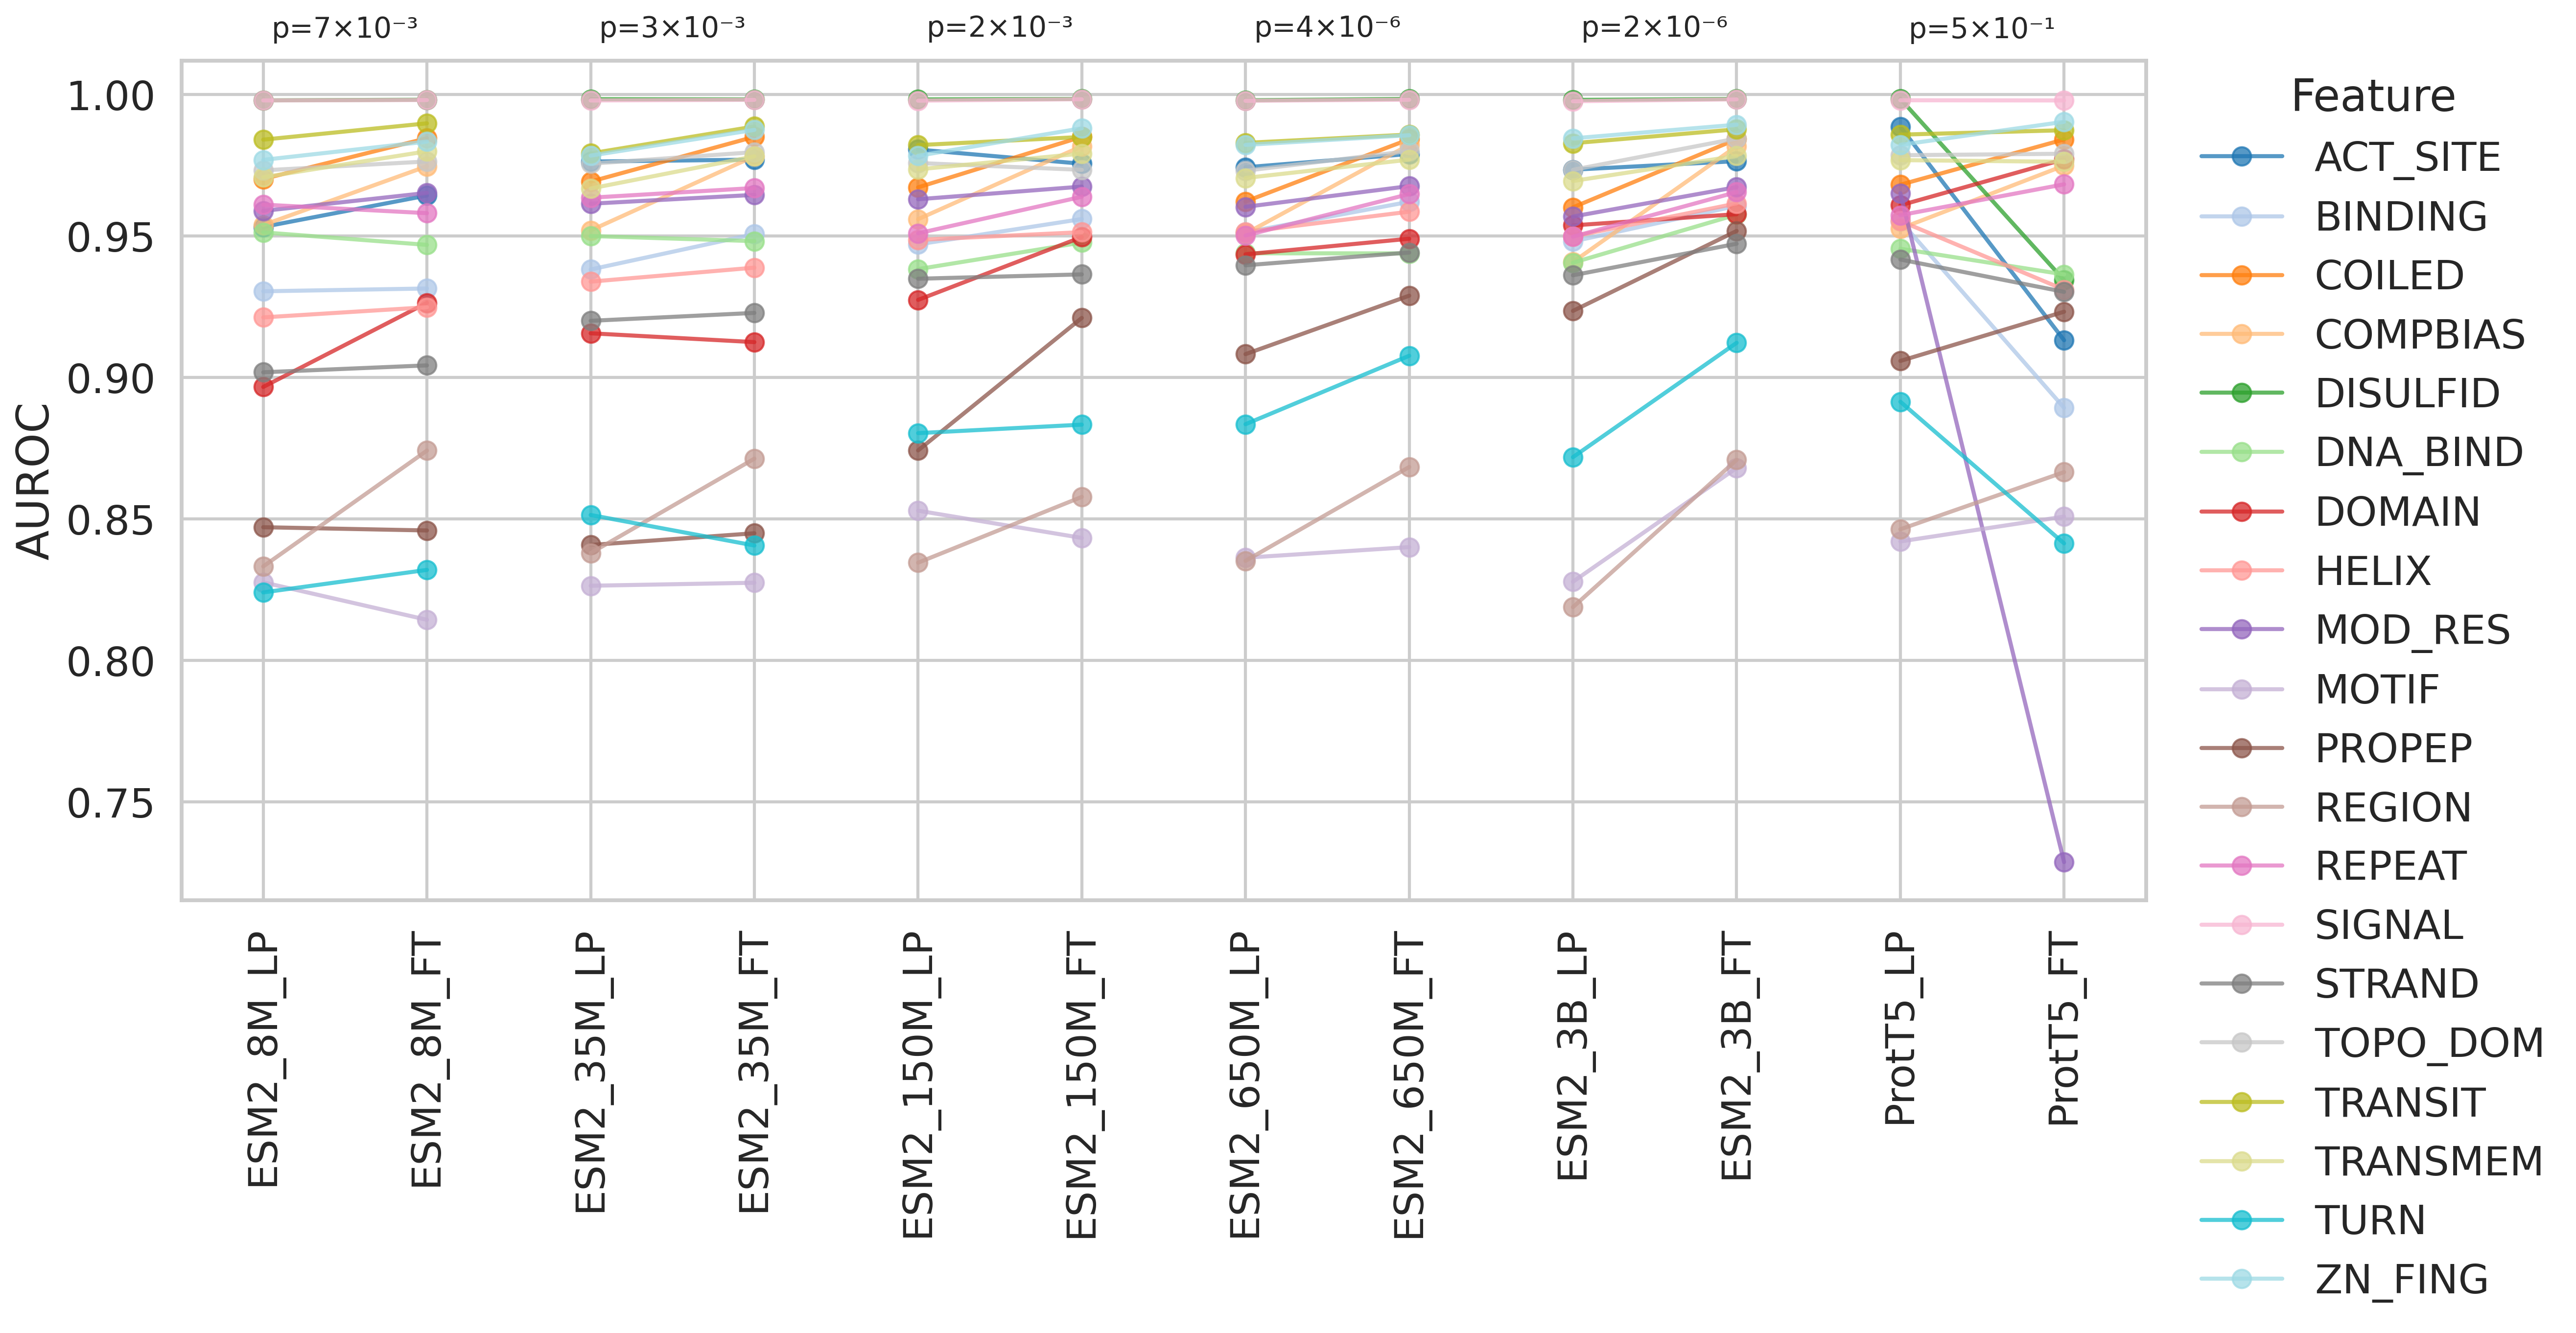

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# Use a clean, publication-quality style
sns.set(style="whitegrid", context="talk", font_scale=1.2)
mpl.rcParams['pdf.fonttype'] = 42  # Ensure editable fonts in PDF (e.g., Illustrator)
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['savefig.dpi'] = 300  # High-resolution output
mpl.rcParams['figure.dpi'] = 300

# Mapping from internal names to display names
model_name_map = {
    'esm2_t6_8M_UR50D': 'ESM2_8M',
    'esm2_t12_35M_UR50D': 'ESM2_35M',
    'esm2_t30_150M_UR50D': 'ESM2_150M',
    'esm2_t33_650M_UR50D': 'ESM2_650M',
    'esm2_t36_3B_UR50D': 'ESM2_3B',
    'prot_t5_xl_uniref50': 'ProtT5',
}

# Custom model order
model_order = list(model_name_map.keys())
setting_order = ["lp", "ft"]
x_order = [f"{model}_{setting}" for model in model_order for setting in setting_order]
x_labels = [f"{model_name_map[model]}_{setting.upper()}" for model in model_order for setting in setting_order]

# Add model_setting column
results_df["model_setting"] = results_df["model"] + "_" + results_df["setting"]
results_df = results_df.sort_values(by=["model", "feature", "setting"])

# Set up figure
fig, ax = plt.subplots(figsize=(18, 9))

# Color palette
num_features = results_df["feature"].nunique()
palette = sns.color_palette("tab20", n_colors=num_features)
feature_to_color = dict(zip(results_df["feature"].unique(), palette))

# X-axis position mapping
x_position_map = {name: idx for idx, name in enumerate(x_order)}

# Plot points and lines
for (model, feature), group in results_df.groupby(["model", "feature"]):
    if len(group) == 2:
        group = group.sort_values(by="setting", key=lambda x: x.map({'lp': 0, 'ft': 1}))
        x_vals = [x_position_map[val] for val in group["model_setting"].values]
        y_vals = group["auroc"].values
        color = feature_to_color[feature]
        ax.plot(x_vals, y_vals, marker='o', color=color, linewidth=2, alpha=0.75, label=feature)

# Format legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(
    by_label.values(), by_label.keys(),
    title="Feature",
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0,
    ncol=1,
    frameon=False
)

# Apply custom x-axis
ax.set_xticks(range(len(x_order)))
ax.set_xticklabels(x_labels, rotation=90)
ax.set_xlim(-0.5, len(x_order) - 0.5)

def format_p_sci(p):
    if p == 0:
        return "p<1×10⁻⁹"
    exponent = int(f"{p:.0e}".split("e")[1])
    base = float(f"{p:.1e}".split("e")[0])
    
    superscript_map = {
        "-": "⁻", "0": "⁰", "1": "¹", "2": "²", "3": "³", "4": "⁴",
        "5": "⁵", "6": "⁶", "7": "⁷", "8": "⁸", "9": "⁹"
    }
    exp_str = "".join(superscript_map[ch] for ch in str(exponent))
    return f"p={base:.0f}×10{exp_str}"


for _, row in stats_df.iterrows():
    model = row["model"]
    p = row["p_value"]
    p_text = format_p_sci(p)
    
    # Get FT x position
    ft_label = f"{model}_ft"
    x = x_position_map.get(ft_label)
    
    # Get y position (max AUROC of FT for this model)
    y = results_df.query("model == @model and setting == 'ft'")["auroc"].max()
    
    if x is not None:
        ax.text(x-0.5, y + 0.02, p_text, ha='center', va='bottom', fontsize=14)


# Axis labels
ax.set_ylabel("AUROC")
ax.set_xlabel("")

plt.tight_layout()
plt.savefig("../res/figures/auroc_lp_ft.pdf", bbox_inches="tight")
plt.savefig("../res/figures/auroc_lp_ft.png", bbox_inches="tight")
plt.show()
